In [ ]:
#General Imports
import pandas as pd
import seaborn as sns
from math import ceil
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import random as rnd
from time import perf_counter as time
from preprocessing_utils import fill_nan_values, drop_features_
from sklearn.linear_model import Lasso
import numpy as np

In [ ]:
dataset_fpath = '../data/BTS1_BTS2_fields_preserved.zip'
nidd_dataset = pd.read_csv(dataset_fpath, compression = 'zip', low_memory=False)

useless_features = ['Attack Tool', 'Attack Type', 'Dport', 'Sport', 'SrcAddr', 'DstAddr',"Unnamed: 0"]
nidd_dataset = nidd_dataset.drop(useless_features, axis=1)
print(f"Original shape of data: {nidd_dataset.shape}")

In [ ]:
features_dropped = {"Nan columns": [], "Zero columns": [], "Constant columns": [], "General columns": useless_features}
preprocessing_d = {"Time <Dropping features based on a threshold `bad` values>": 0.,
                   "Filling NaNs": 0.,
                   "Time <Encoding categorical features>": 0.,
                   "Time <Feature selection>": 0.}



nidd_dataset_cleaned, drop_time = drop_features_(nidd_dataset,[0.95, 0.95], features_dropped)
preprocessing_d["Time <Dropping features based on a threshold `bad` values>"] = drop_time

nidd_dataset_cleaned, fill_time = fill_nan_values(nidd_dataset_cleaned, method = "mean")
preprocessing_d["Filling NaNs"] = fill_time

numeric_cols = nidd_dataset_cleaned.select_dtypes(include='number').columns
categorical_cols = nidd_dataset_cleaned.select_dtypes(include='object').columns

t0 = time()
# Encoding categorical columns
label_encoder = LabelEncoder()
for column in categorical_cols:
    nidd_dataset_cleaned[column] = label_encoder.fit_transform(nidd_dataset_cleaned[column])

t1 = time()
preprocessing_d["Time <Encoding categorical features>"] = t1 - t0


In [ ]:
stdsc = StandardScaler()
print(f"numeric_cols: {numeric_cols} \n {type(nidd_dataset_cleaned)}")
nidd_dataset_X = stdsc.fit_transform(nidd_dataset_cleaned[numeric_cols])

print(type(nidd_dataset_X))
sc_test = np.concatenate([nidd_dataset_X, nidd_dataset_cleaned[categorical_cols]], axis = 1)
LassoModel = Lasso(alpha = 0.1)
LassoModel.fit(nidd_dataset_cleaned.iloc[:,:-1], nidd_dataset_cleaned['Label'])
useful_features = np.where(LassoModel.coef_ != 0)


In [ ]:
print(sorted(LassoModel.coef_ , key = lambda x: abs(x)))
useful_features = sorted(np.where(LassoModel.coef_ != 0), key = lambda x: abs(LassoModel.coef_[x]))
print(useful_features)
print(useful_features[0][::-1])

test = nidd_dataset_cleaned.columns.to_numpy()[useful_features[0][::-1]]
top_10_features = test[:10]
print(top_10_features,len(test))

In [32]:


X_train, X_test, y_train, y_test = train_test_split(nidd_dataset_cleaned[top_10_features], nidd_dataset_cleaned.iloc[:,-1], 
                                                    test_size=0.3, random_state=rnd.seed(42)) 

numeric_features = list(set(numeric_cols) & set(top_10_features))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(),numeric_features ),
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)


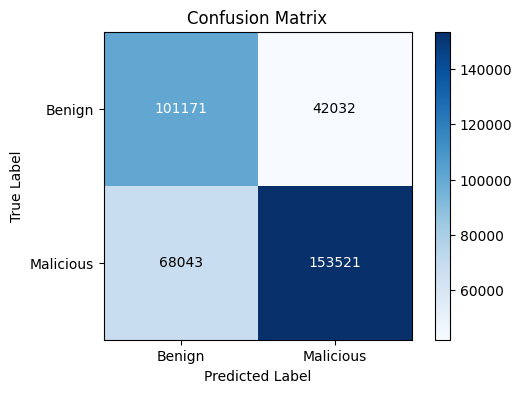

Classification Report:
               precision    recall  f1-score   support

      Benign   0.597888  0.706487  0.647666    143203
   Malicious   0.785061  0.692897  0.736105    221564

    accuracy                       0.698232    364767
   macro avg   0.691474  0.699692  0.691886    364767
weighted avg   0.711579  0.698232  0.701385    364767

Time <Dropping features based on a threshold `bad` values>: 2.7368 seconds
Filling NaNs: 2.5168 seconds
Time <Encoding categorical features>: 1.8012 seconds
Time <Feature selection>: 0.0000 seconds


In [33]:
conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=[0, 1], labels=['Benign', 'Malicious'])
plt.yticks(ticks=[0, 1], labels=['Benign', 'Malicious'])
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

class_report = classification_report(y_test, predictions, target_names=['Benign', 'Malicious'], digits=6)
print("Classification Report:\n", class_report)
for key, time in preprocessing_d.items():
    print(f"{key}: {time:.4f} seconds")
